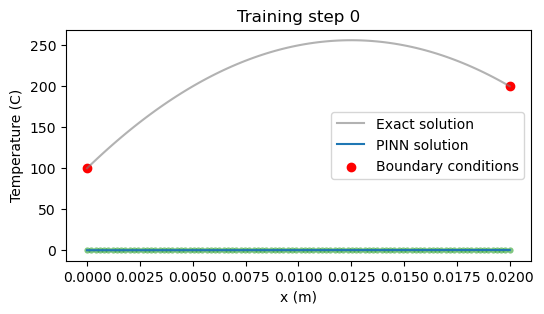

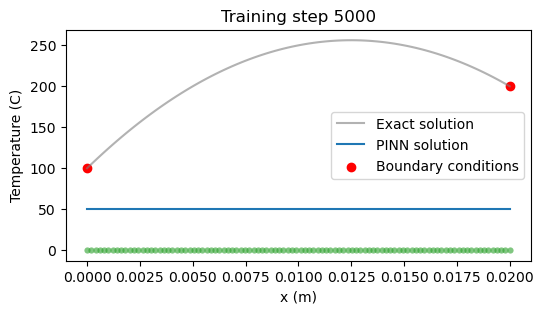

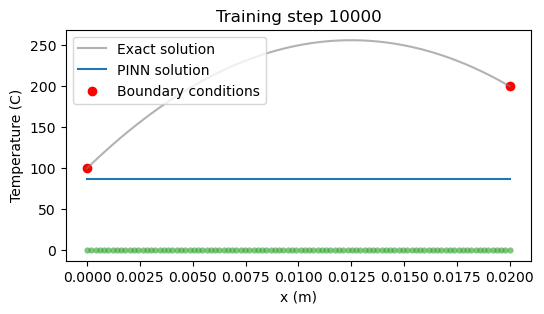

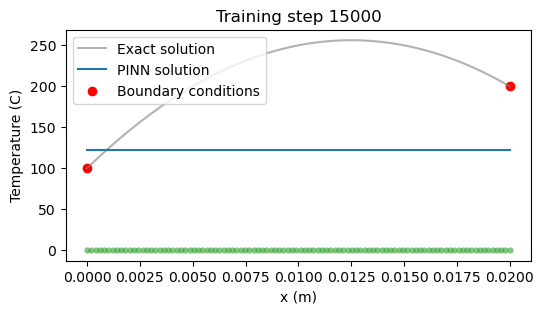

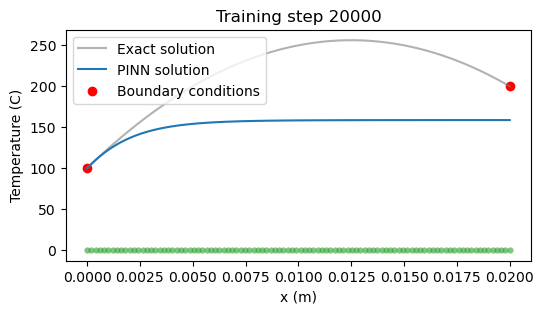

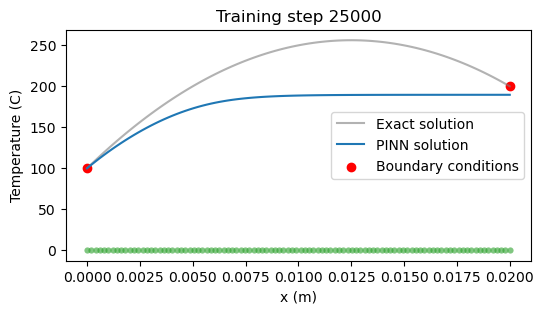

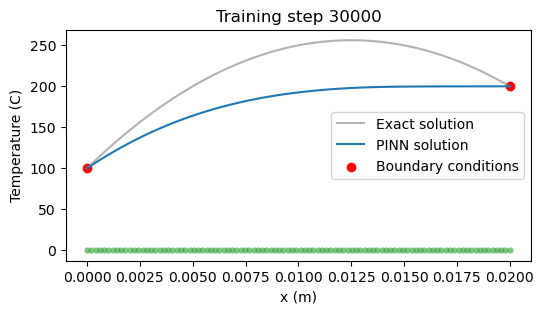

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Parameters
k = 0.5  # Thermal conductivity in W/m.K
q = 1e6  # Heat generation in W/m^3
L = 0.02  # Thickness of the plate in m
T_A, T_B = 100, 200  # Boundary temperatures at x = 0 and x = L

# Analytical solution for comparison
def exact_temperature(x_norm):
    x_physical = x_norm * L
    return -q / (2 * k) * x_physical**2 + ((T_B - T_A) / L + q * L / (2 * k)) * x_physical + T_A

# Define the neural network
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.fch = nn.Sequential(*[nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

torch.manual_seed(123)
pinn = FCN(1, 1, 80, 4)  # Increased network capacity

# Boundary points and collocation points for physics loss
x_boundary_A = torch.tensor([0.0], requires_grad=True).view(-1, 1)
x_boundary_B = torch.tensor([1.0], requires_grad=True).view(-1, 1)
x_physics = torch.linspace(0, 1, 100, requires_grad=True).view(-1, 1)  # Increased number of collocation points

# Optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)

# Training loop
lambda1, lambda2 = 1.0, 1e-12  # Adjusted weights

for i in range(30001):
    optimizer.zero_grad()

    # Boundary condition loss
    T_A_pred = pinn(x_boundary_A)
    T_B_pred = pinn(x_boundary_B)
    loss_boundary = (T_A_pred - T_A)**2 + (T_B_pred - T_B)**2

    # Physics loss (governing equation)
    T_pred = pinn(x_physics)
    dT_dx = torch.autograd.grad(T_pred, x_physics, torch.ones_like(T_pred), create_graph=True)[0]
    d2T_dx2 = torch.autograd.grad(dT_dx, x_physics, torch.ones_like(dT_dx), create_graph=True)[0]
    
    # Convert normalized coordinates derivatives to physical coordinates
    d2T_dx2_physical = d2T_dx2 / (L**2)
    loss_physics = torch.mean((k * d2T_dx2_physical + q)**2)

    # Total loss
    loss = lambda1 * loss_boundary + lambda2 * loss_physics
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    # Plot the result as training progresses
    if i % 5000 == 0:
        x_test = torch.linspace(0, 1.0, 100).view(-1, 1)
        T_exact = exact_temperature(x_test.numpy())
        T_pinn = pinn(x_test).detach().numpy()

        plt.figure(figsize=(6, 3))
        plt.plot(x_test * L, T_exact, label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test * L, T_pinn, label="PINN solution", color="tab:blue")
        plt.scatter(x_physics.detach() * L, torch.zeros_like(x_physics), s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter([0, L], [T_A, T_B], color="red", label="Boundary conditions")
        plt.title(f"Training step {i}")
        plt.xlabel("x (m)")
        plt.ylabel("Temperature (C)")
        plt.legend()
        plt.show()

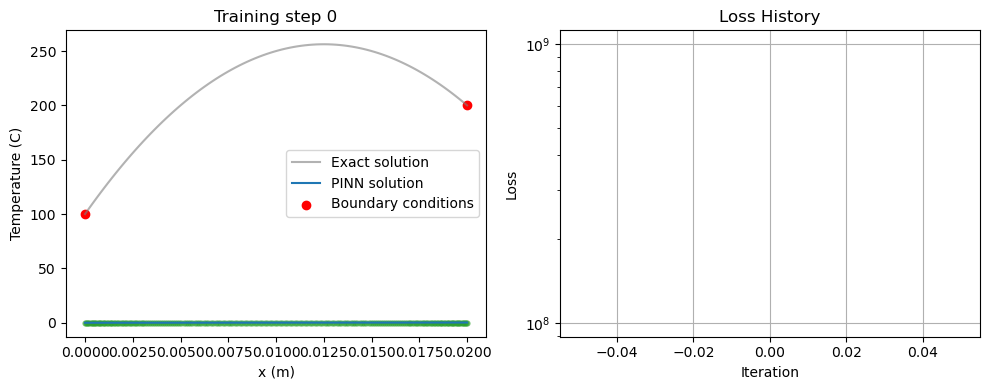

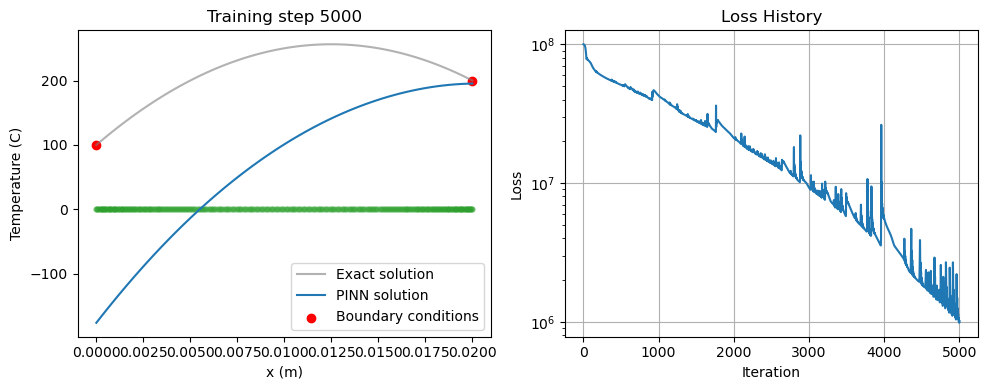

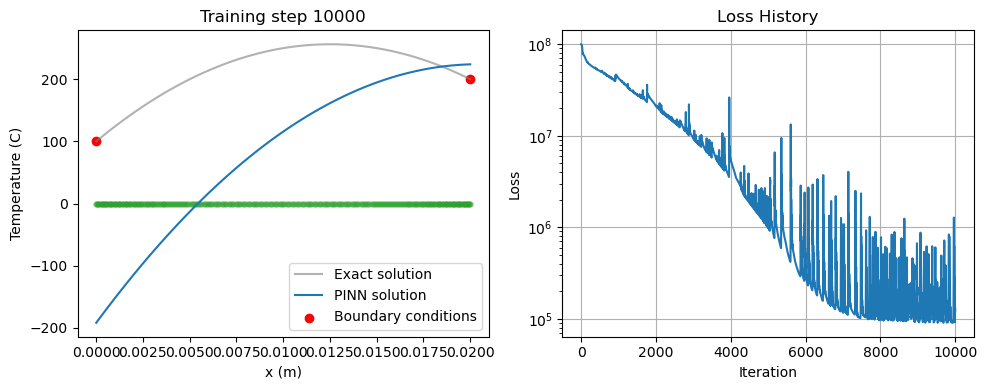

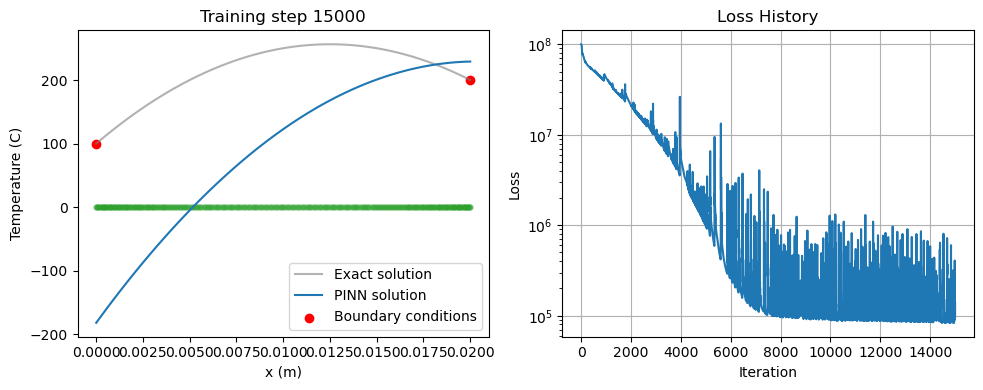

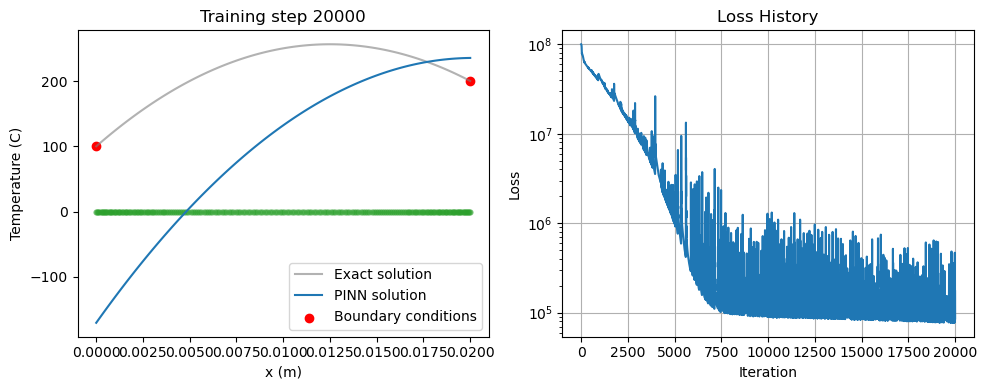

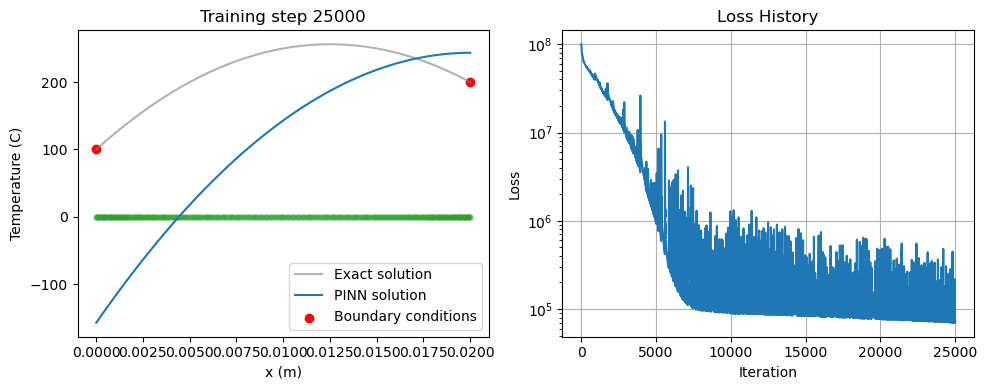

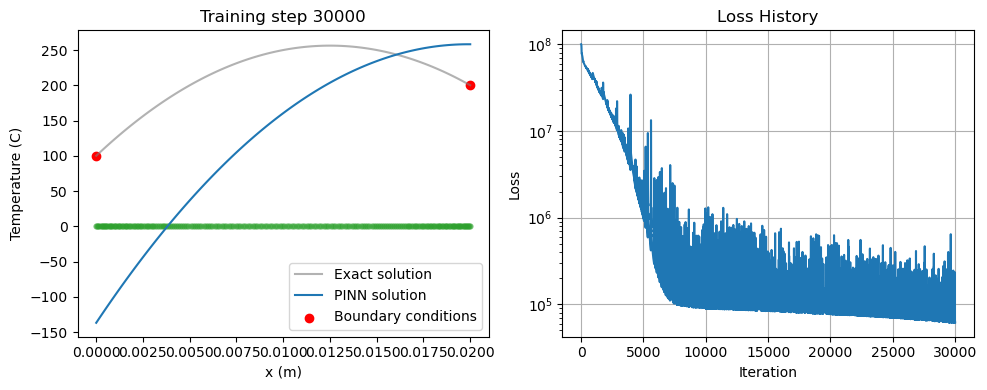

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Parameters
k = 0.5  # Thermal conductivity in W/m.K
q = 1e6  # Heat generation in W/m^3
L = 0.02  # Thickness of the plate in m
T_A, T_B = 100, 200  # Boundary temperatures at x = 0 and x = L

# Analytical solution for comparison
def exact_temperature(x_norm):
    x_physical = x_norm * L
    return -q / (2 * k) * x_physical**2 + ((T_B - T_A) / L + q * L / (2 * k)) * x_physical + T_A

# Define the neural network with skip connections
class ImprovedFCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        # Input layer
        self.input_layer = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        
        # Hidden layers with skip connections
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(N_HIDDEN + N_INPUT, N_HIDDEN),  # +N_INPUT for skip connection
                activation()
            ) for _ in range(N_LAYERS - 1)
        ])
        
        # Output layer
        self.output_layer = nn.Linear(N_HIDDEN + N_INPUT, N_OUTPUT)  # +N_INPUT for skip connection
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        input_copy = x  # Store input for skip connections
        
        # Input layer
        x = self.input_layer(x)
        
        # Hidden layers with skip connections
        for layer in self.hidden_layers:
            x = layer(torch.cat([x, input_copy], dim=1))
            
        # Output layer with skip connection
        x = self.output_layer(torch.cat([x, input_copy], dim=1))
        return x

# Set random seed for reproducibility
torch.manual_seed(123)

# Create PINN with improved architecture
pinn = ImprovedFCN(1, 1, 64, 4)

# Create training points with adaptive distribution
def generate_training_points(n_points, concentration_factor=2.0):
    # Generate points with higher density in the middle
    uniform = torch.linspace(0, 1, n_points)
    transformed = torch.tanh(concentration_factor * (uniform - 0.5)) / torch.tanh(torch.tensor(concentration_factor/2.0)) / 2.0 + 0.5
    return transformed.view(-1, 1).requires_grad_(True)

# Training points
x_boundary_A = torch.tensor([0.0], requires_grad=True).view(-1, 1)
x_boundary_B = torch.tensor([1.0], requires_grad=True).view(-1, 1)
x_physics = generate_training_points(200)  # Increased number of points with adaptive distribution

# Optimizer with improved parameters
optimizer = torch.optim.Adam([
    {'params': pinn.parameters(), 'lr': 1e-3}
])

# Custom scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1000, verbose=True, min_lr=1e-6
)

# Training loop with balanced loss weights
lambda1, lambda2 = 1.0, 1e-4  # Increased physics loss weight

losses = []
for i in range(30001):
    optimizer.zero_grad()

    # Boundary condition loss
    T_A_pred = pinn(x_boundary_A)
    T_B_pred = pinn(x_boundary_B)
    loss_boundary = (T_A_pred - T_A)**2 + (T_B_pred - T_B)**2

    # Physics loss (governing equation)
    T_pred = pinn(x_physics)
    dT_dx = torch.autograd.grad(T_pred, x_physics, torch.ones_like(T_pred), create_graph=True)[0]
    d2T_dx2 = torch.autograd.grad(dT_dx, x_physics, torch.ones_like(dT_dx), create_graph=True)[0]
    
    # Convert normalized coordinates derivatives to physical coordinates
    d2T_dx2_physical = d2T_dx2 / (L**2)
    loss_physics = torch.mean((k * d2T_dx2_physical + q)**2)

    # Total loss with adaptive weighting
    loss = lambda1 * loss_boundary + lambda2 * loss_physics
    
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    losses.append(loss.item())

    # Plot the result as training progresses
    if i % 5000 == 0:
        with torch.no_grad():
            x_test = torch.linspace(0, 1.0, 100).view(-1, 1)
            T_exact = exact_temperature(x_test.numpy())
            T_pinn = pinn(x_test).numpy()

            plt.figure(figsize=(10, 4))
            
            # Plot temperature distribution
            plt.subplot(1, 2, 1)
            plt.plot(x_test * L, T_exact, label="Exact solution", color="tab:grey", alpha=0.6)
            plt.plot(x_test * L, T_pinn, label="PINN solution", color="tab:blue")
            plt.scatter(x_physics.detach() * L, torch.zeros_like(x_physics), s=20, lw=0, color="tab:green", alpha=0.6)
            plt.scatter([0, L], [T_A, T_B], color="red", label="Boundary conditions")
            plt.title(f"Training step {i}")
            plt.xlabel("x (m)")
            plt.ylabel("Temperature (C)")
            plt.legend()
            
            # Plot loss history
            plt.subplot(1, 2, 2)
            plt.semilogy(losses)
            plt.title("Loss History")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()

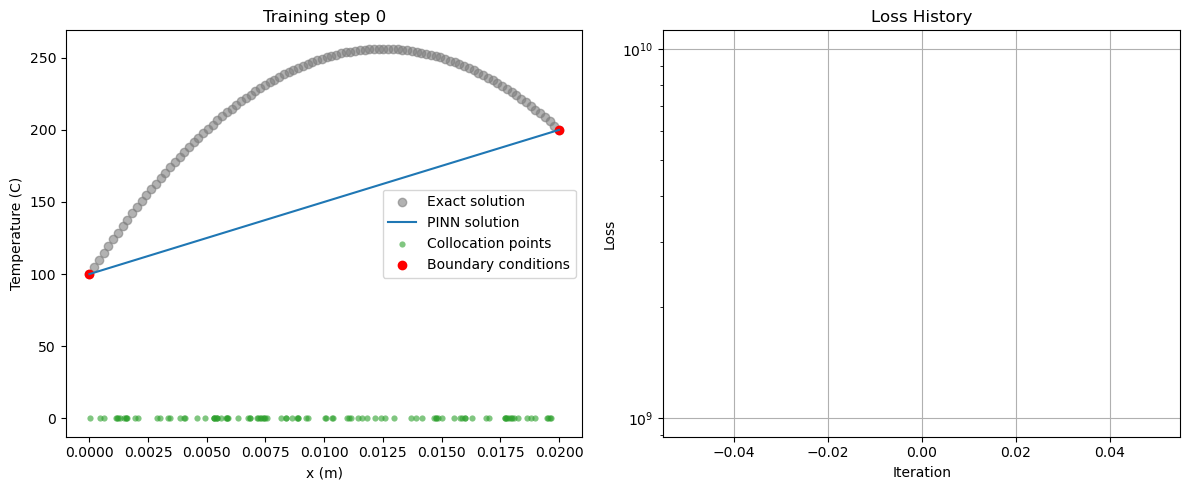

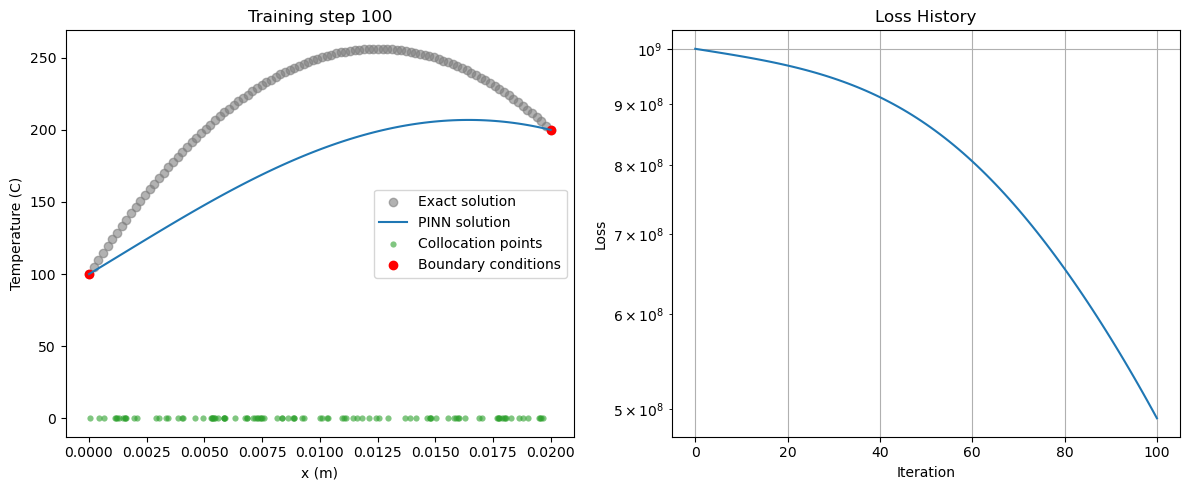

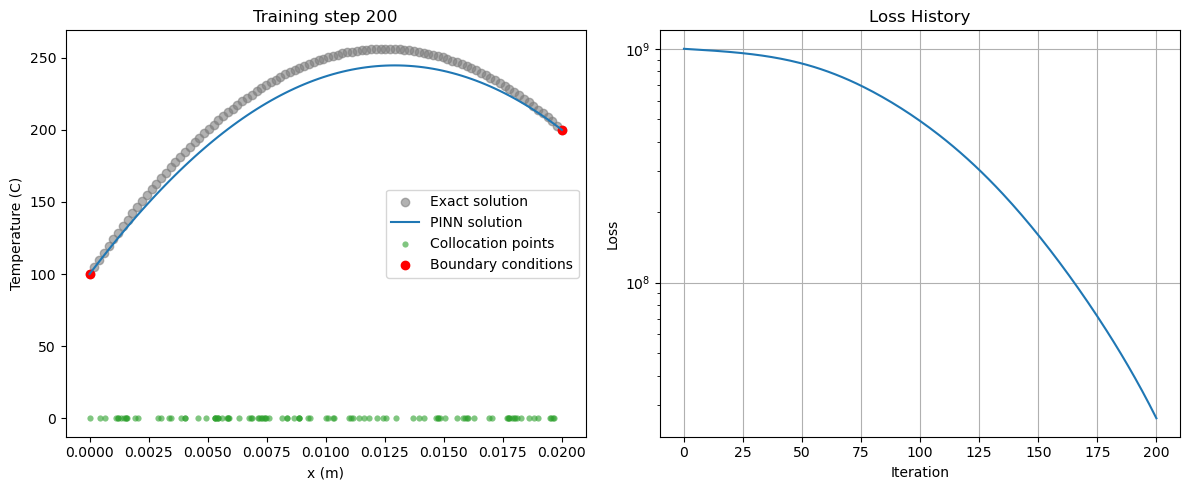

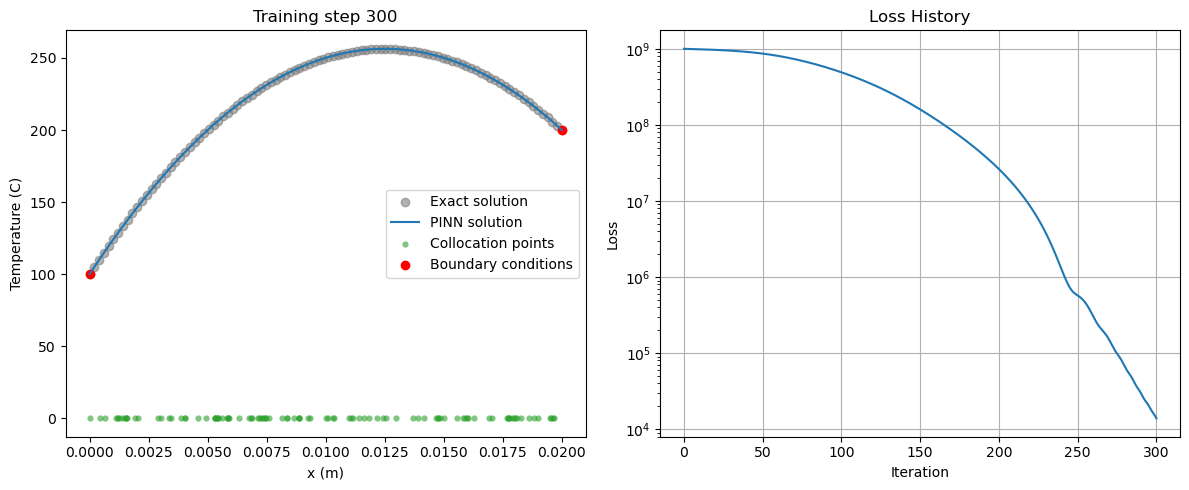

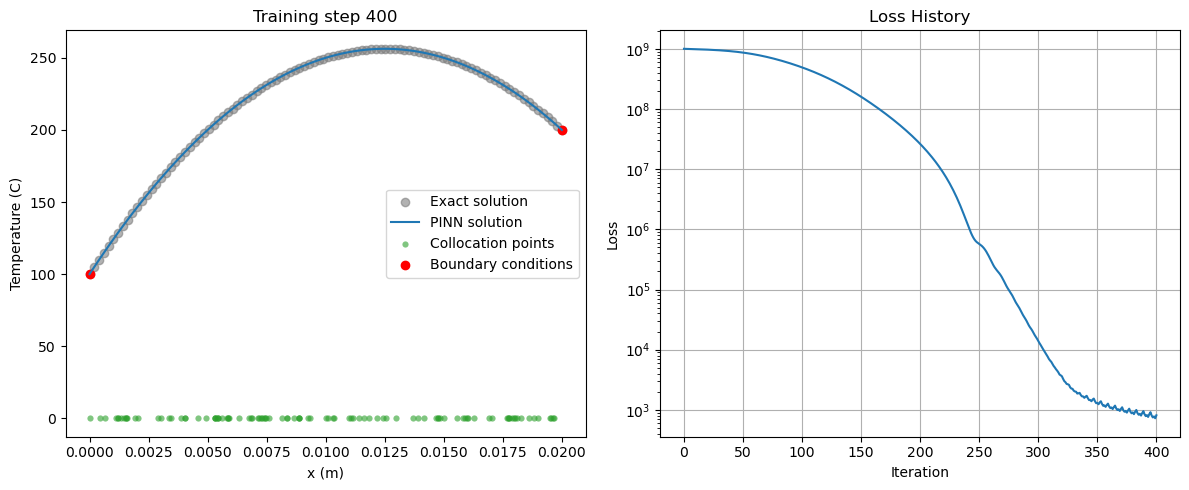

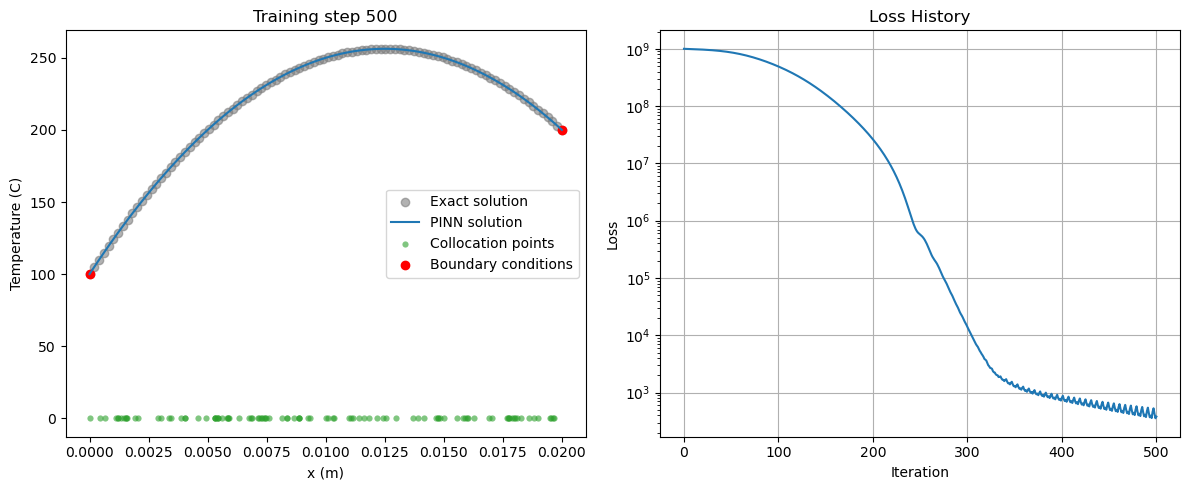

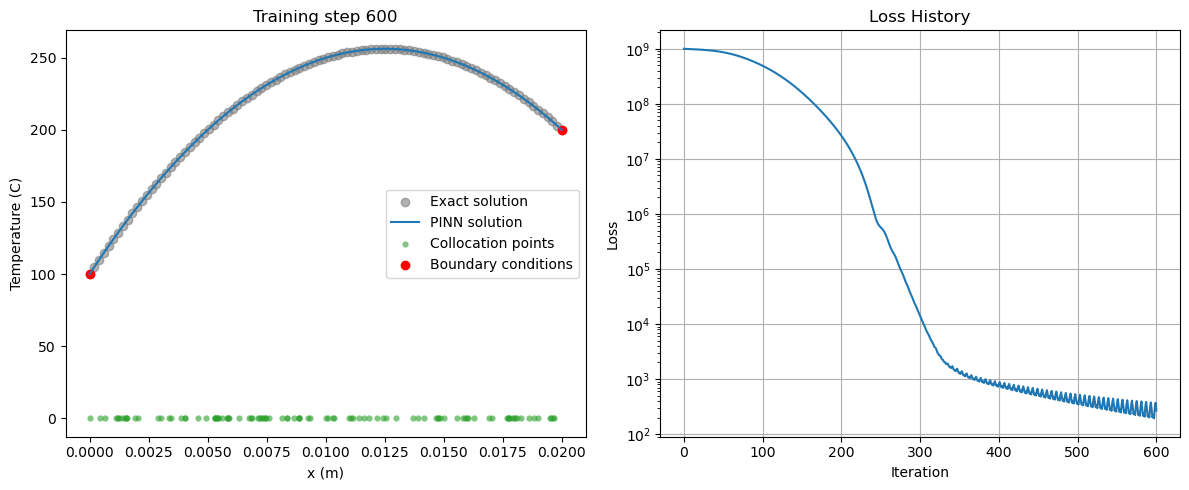

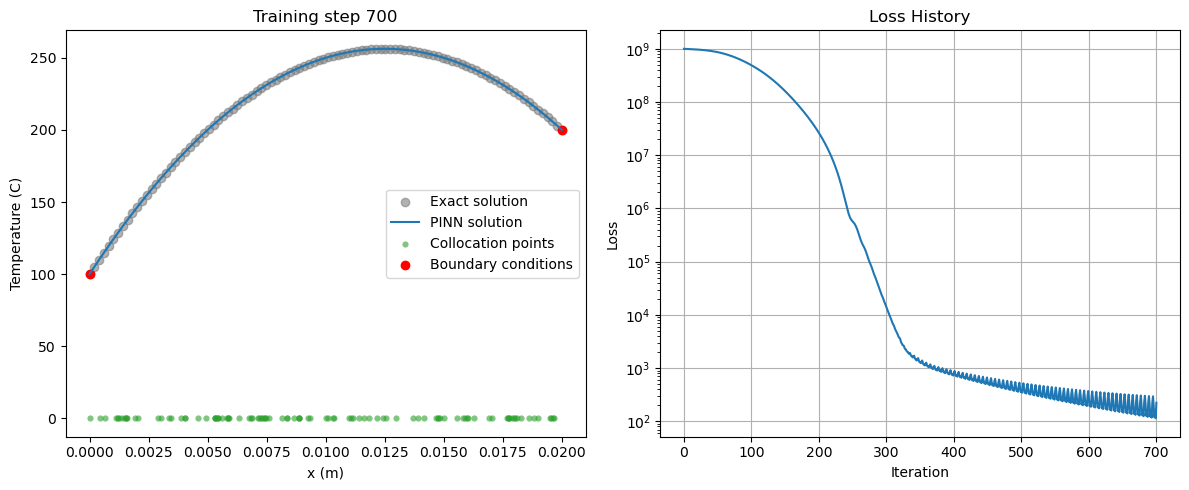

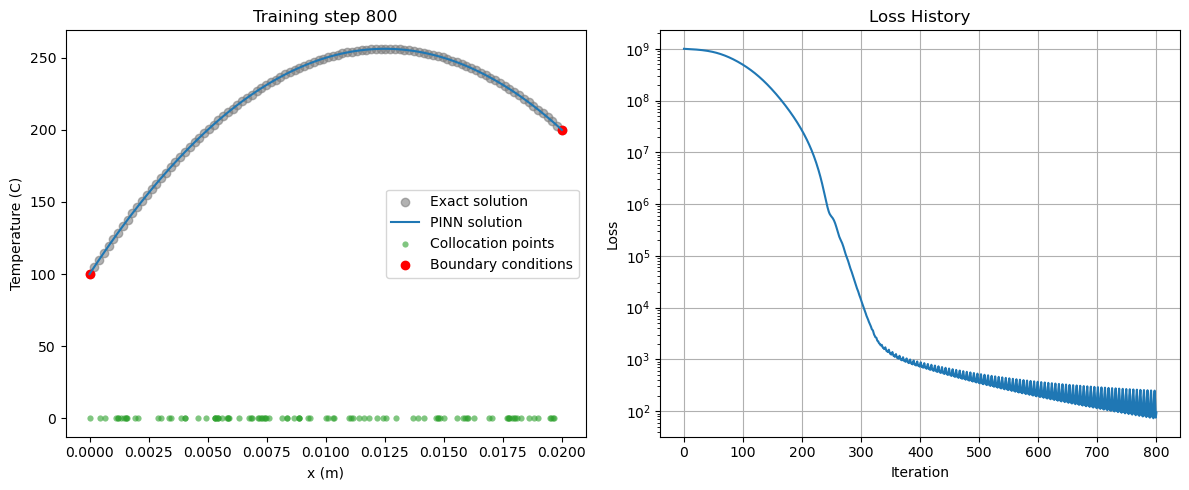

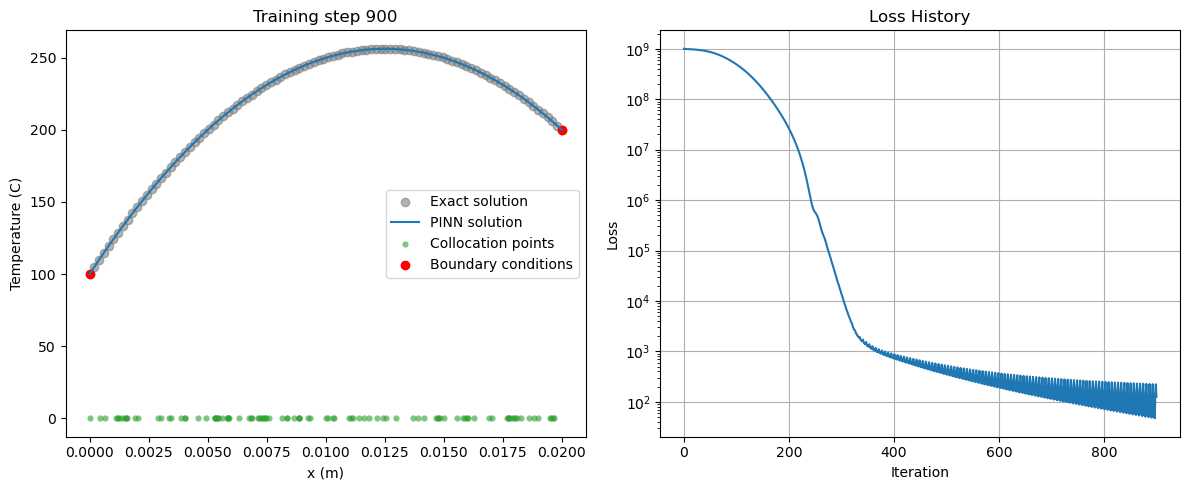

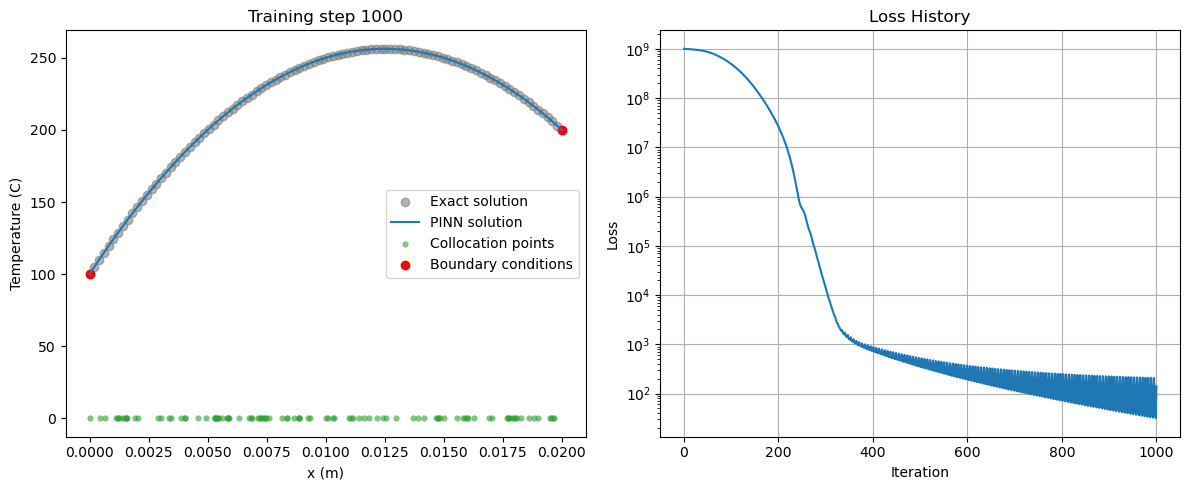

In [12]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt

# Set default tensor type to float32
torch.set_default_tensor_type(torch.FloatTensor)

# Parameters
k = 0.5  # Thermal conductivity in W/m.K
q = 1e6  # Heat generation in W/m^3
L = 0.02  # Thickness of the plate in m
T_A = torch.tensor(100.0, dtype=torch.float32)  # Explicit float32 type
T_B = torch.tensor(200.0, dtype=torch.float32)  # Explicit float32 type

# Analytical solution for comparison
def exact_temperature(x_norm):
    x_physical = x_norm * L
    return -q / (2 * k) * x_physical**2 + ((T_B.item() - T_A.item()) / L + q * L / (2 * k)) * x_physical + T_A.item()

# Define the neural network
class StableFCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        
        # Initialize weights with smaller values for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Ensure input is float32
        x = x.to(torch.float32)
        # Enforce solution bounds using a learned residual approach
        base_solution = T_A + x * (T_B - T_A)  # Linear interpolation between boundaries
        residual = self.network(x)
        # Scale the residual to help maintain physical bounds
        scaled_residual = residual * 0.5 * (T_B - T_A) * (1 - x) * x
        return base_solution + scaled_residual

torch.manual_seed(123)
pinn = StableFCN()

# Training points with focused distribution
x_boundary_A = torch.tensor([[0.0]], requires_grad=True, dtype=torch.float32)
x_boundary_B = torch.tensor([[1.0]], requires_grad=True, dtype=torch.float32)

# Generate collocation points with higher density in the middle
n_points = 100
x_physics = torch.tensor(np.random.uniform(0, 1, (n_points, 1)), 
                        requires_grad=True, 
                        dtype=torch.float32)

# Optimizer with more conservative learning rate
optimizer = torch.optim.AdamW(pinn.parameters(), lr=5e-4, weight_decay=1e-5)

# More gradual learning rate decay
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.8, patience=1000, verbose=True, min_lr=1e-6
)

# Training loop with carefully balanced loss weights
lambda1, lambda2 = 1.0, 1e-3  # Adjusted weights

losses = []
for i in range(1001):
    optimizer.zero_grad()

    # Boundary condition loss
    T_A_pred = pinn(x_boundary_A)
    T_B_pred = pinn(x_boundary_B)
    loss_boundary = (T_A_pred - T_A)**2 + (T_B_pred - T_B)**2

    # Physics loss (governing equation)
    T_pred = pinn(x_physics)
    dT_dx = torch.autograd.grad(T_pred, x_physics, torch.ones_like(T_pred), create_graph=True)[0]
    d2T_dx2 = torch.autograd.grad(dT_dx, x_physics, torch.ones_like(dT_dx), create_graph=True)[0]
    
    # Convert normalized coordinates derivatives to physical coordinates
    d2T_dx2_physical = d2T_dx2 / (L**2)
    loss_physics = torch.mean((k * d2T_dx2_physical + q)**2)

    # Add physical constraint loss to encourage realistic temperatures
    T_min = min(T_A.item(), T_B.item()) - 10
    T_max = max(T_A.item(), T_B.item()) + 50
    physics_samples = pinn(x_physics)
    constraint_loss = torch.mean(torch.relu(T_min - physics_samples) + torch.relu(physics_samples - T_max))
    
    # Total loss
    loss = lambda1 * loss_boundary + lambda2 * loss_physics + 0.1 * constraint_loss
    
    loss.backward()
    # Gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), 1.0)
    optimizer.step()
    scheduler.step(loss)
    
    losses.append(loss.item())

    # Plot results periodically
    if i % 100 == 0:
        with torch.no_grad():
            x_test = torch.linspace(0, 1.0, 100, dtype=torch.float32).view(-1, 1)
            T_exact = exact_temperature(x_test.numpy())
            T_pinn = pinn(x_test).numpy()

            plt.figure(figsize=(12, 5))
            
            # Plot temperature distribution
            plt.subplot(1, 2, 1)
            plt.scatter(x_test * L, T_exact, label="Exact solution", color="tab:grey", alpha=0.6)
            plt.plot(x_test * L, T_pinn, label="PINN solution", color="tab:blue")
            plt.scatter(x_physics.detach() * L, torch.zeros_like(x_physics), s=20, lw=0, 
                       color="tab:green", alpha=0.6, label="Collocation points")
            plt.scatter([0, L], [T_A.item(), T_B.item()], color="red", label="Boundary conditions")
            plt.title(f"Training step {i}")
            plt.xlabel("x (m)")
            plt.ylabel("Temperature (C)")
            plt.legend()
            
            # Plot loss history
            plt.subplot(1, 2, 2)
            plt.semilogy(losses)
            plt.title("Loss History")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()

In [ ]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Exact solution
def exact_solution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

# Network (Method 1 in terms of code structure)
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    

    torch.manual_seed(123)

# Instantiate Neural Network
pinn = FCN(1,1,32,3)

# Boundary points and collocation points for physics loss
t_boundary = torch.tensor(0., requires_grad=True).view(-1,1)
t_physics = torch.linspace(0, 1, 30, requires_grad=True).view(-1,1) # collocation points

# Train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1, 300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

for i in range(15001):
    optimizer.zero_grad()

    # compute PINN loss
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    u = pinn(t_boundary)
    loss1 = torch.squeeze((u - 1)**2)
    du = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = torch.squeeze((du - 0)**2)

    # compute physics loss
    u = pinn(t_physics)
    du = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    du2 = torch.autograd.grad(du, t_physics, torch.ones_like(u), create_graph=True)[0]
    loss3 = torch.mean((du2+mu*du+k*u)**2)

    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimizer.step()

    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
